# NOAA Nearshore Wave Prediction System SWAN wave model

As a part of the continuous Marine Data support, this week Planet OS Team releases a set of the new hyper-local wind & wave forecast datasets based on the SWAN model to the __[Planet OS Datahub](http://data.planetos.com)__.
Coastal communities, businesses, and professionals are relying on the quality of the marine weather predictions. From major weather events like storms or hurricanes down to daily check on what is the best time to go to the beach, reliable marine weather models affect the lives of millions.

Nearshore Wave Prediction System (NWPS) provides on-demand, high-resolution nearshore wave model guidance to US coastal Weather Forecast Offices (WFOs), triggered in real time by forecast wind grids prepared and submitted by the individual offices. NWPS is driven by forecaster-developed wind grids produced in AWIPS, and wave boundary conditions from the operational WAVEWATCH III model. The model core used is the spectral wind-wave model SWAN. Wave-current interaction is included using surface currents from the Real-Time Ocean Forecast System (RTOFS-Global).

With this release, we hope more app developers and domain experts would jump on board and create value-add applications and extend their customer base in marine navigation, coastal tourism, aquaculture, and other related domains.
We also hope that businesses could utilize such data in their business analytics to derive valuable insights for operations, planning and risk assessments.

Let's start with the code now. For preventing issues with version incompatibility, we'll print out some most important module versions. Also, make sure you are using __python3__

In [1]:
%matplotlib inline
import numpy as np
from dh_py_access import package_api
import dh_py_access.lib.datahub as datahub
import xarray as xr
import PIL
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import datetime
import imageio
import json
import os
import shutil
from mpl_toolkits.basemap import Basemap
import ipywidgets as widgets
from po_data_process import read_data_to_json
import warnings
warnings.filterwarnings("ignore")
import matplotlib
print('matplotlib', matplotlib.__version__)
print ('widgets', widgets.__version__)
print ('imageio',imageio.__version__)
print ('xarray',xr.__version__)

matplotlib 3.0.3
widgets 6.0.0
imageio 2.2.0
xarray 0.10.8


API documentation is available at http://docs.planetos.com. If you have questions or comments, join the Planet OS Slack community to chat with our development team. For general information on usage of IPython/Jupyter and Matplotlib, please refer to their corresponding documentation. https://ipython.org/ and http://matplotlib.org/


<font color='red'>Please put your datahub API key into a file called APIKEY and place it to the notebook folder or assign your API key directly to the variable API_key!</font>

In [2]:
server = 'api.planetos.com'
API_key = open('APIKEY').readlines()[0].strip() #'<YOUR API KEY HERE>'
version = 'v1'

This time we decided to add some NOAA NWPS SWAN models from US Southern East coast. We added several models from the area, however, almost all the US coast can be covered. If you are interested in other regions, just let us know! Here,  we will find out which NOAA swan datasets we have already ingested:

In [3]:
datasets = read_data_to_json('https://api.planetos.com/v1/datasets?apikey={0}'.format(API_key))
swan_datasets = ['https://data.planetos.com/{0}'.format(d) for d in datasets if 'swan' in d]
print ("\n".join(swan_datasets))

https://data.planetos.com/noaa_swan_houston
https://data.planetos.com/noaa_swan_corpus_christi
https://data.planetos.com/noaa_swan_brownsville
https://data.planetos.com/noaa_swan_lake_charles
https://data.planetos.com/noaa_swan_miami
https://data.planetos.com/noaa_swan_melbourne
https://data.planetos.com/noaa_swan_san_juan
https://data.planetos.com/noaa_swan_jacksonville
https://data.planetos.com/noaa_swan_new_orleans
https://data.planetos.com/noaa_swan_pensacola
https://data.planetos.com/noaa_swan_tampa
https://data.planetos.com/noaa_swan_tallahassee
https://data.planetos.com/pacioos_swan_oahu
https://data.planetos.com/noaa_swan_key_west


Possible area that could be covered can be seen from NOAA image below. Area from the Southern Region is already covered. 

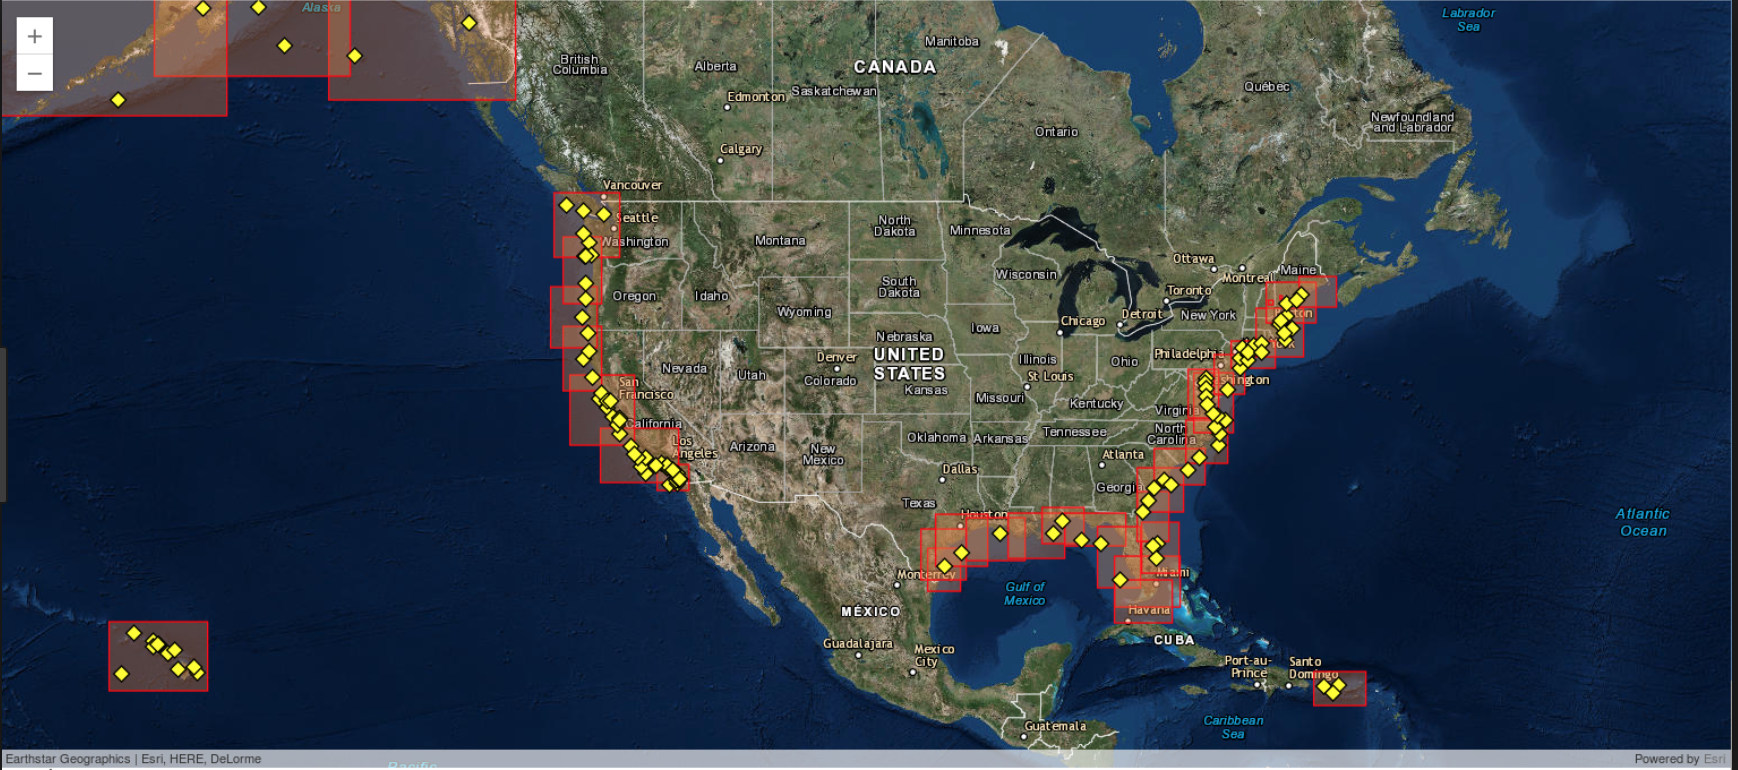

In [4]:
image = PIL.Image.open('swan_region.png')
image

Now we need to define the dataset name and variables we want to use. This time we use __[Swan model from Key West](http://data.planetos.com/datasets/noaa_swan_key_west)__, as it's updating on regular bases in Datahub. For swan model we want to get all the variables, so we make API query to get all variable names. We also add dataset2 as __[NOAA WW3 global](http://data.planetos.com/datasets/noaa_ww3_global_0.5d)__ to show the resolution difference on regional and global datasets. Region will be defined by noaa_swan_key_west coordinate values that we geo from the API. 

In [5]:
dh=datahub.datahub(server,version,API_key)
dataset1 = 'noaa_swan_key_west'

link = 'https://api.planetos.com/v1/datasets/{0}?apikey={1}'.format(dataset1,API_key)
meta = read_data_to_json(link)
variable_names1 = [v['name'] for v in meta['Variables'] if  v['isData'] == True]

dataset2 = 'noaa_ww3_global_0.5d'
variable_names2 = 'Significant_height_of_primary_swell_waves'
time_start = datetime.datetime.now()
time_end = time_start + datetime.timedelta(days=8)
area_name = 'key_west'

coords = meta['SpatialExtent']['coordinates'][0]
lats = [c[1] for c in coords]
lons = [c[0] for c in coords]
latitude_north = np.max(lats); longitude_west = np.min(lons)
latitude_south = np.min(lats); longitude_east = np.max(lons)

### Download the data with package API

1. Create package objects
2. Send commands for the package creation
3. Download the package files

In [6]:
package_swan = package_api.package_api(dh,dataset1,variable_names1,longitude_west,longitude_east,latitude_south,latitude_north,area_name=area_name)
package_ww3 = package_api.package_api(dh,dataset2,variable_names2,longitude_west,longitude_east,latitude_south,latitude_north,area_name=area_name)

In [7]:
package_swan.make_package()
package_ww3.make_package()

In [8]:
package_swan.download_package()
package_ww3.download_package()

## Work with downloaded files

We start by opening the files with xarray, then we define Basemap we want to use for showing data. After that we can compare two datasets.

In [9]:
dd_swan = xr.open_dataset(package_swan.local_file_name)
dd_ww3 = xr.open_dataset(package_ww3.local_file_name)

In [10]:
dd_swan['lon'] = ((dd_swan.lon+180) % 360) - 180
dd_ww3['lon'] = ((dd_ww3.lon+180) % 360) - 180
m = Basemap(projection='merc', lat_0 = 55, lon_0 = -4,
         resolution = 'i', area_thresh = 0.05,
         llcrnrlon=longitude_west, llcrnrlat=latitude_south,
         urcrnrlon=longitude_east, urcrnrlat=latitude_north)
lons_swan,lats_swan = np.meshgrid(dd_swan.lon.data,dd_swan.lat.data)
lonmap_swan,latmap_swan = m(lons_swan,lats_swan)

lons_ww3,lats_ww3 = np.meshgrid(dd_ww3.lon.data,dd_ww3.lat.data)
lonmap_ww3,latmap_ww3 = m(lons_ww3,lats_ww3)

Here we make __[NOAA WW3 global](http://data.planetos.com/datasets/noaa_ww3_global_0.5d)__ and __[NOAA SWAN Key West](http://data.planetos.com/datasets/noaa_swan_key_west)__ dataset comparison. We can clearly see how much better overview from the coastel area we can get from the Swan dataset that has spatial resolution 0.03 degree, while WW3 has resolution 0.5 degree. Here, we look into significant swell height data and for swan dataset, complex topography near the shoreline is taken account which make data more accurate.   

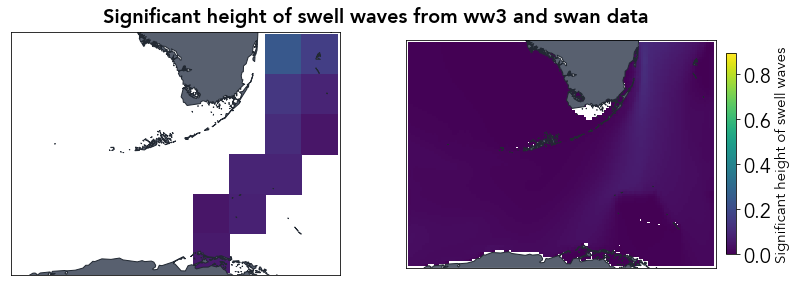

In [12]:
i=3
vmin = np.nanmin([np.nanmin(dd_swan.Significant_height_of_swell_waves_surface[dd_swan['time'] == dd_ww3.time[i].values]),np.nanmin(dd_ww3.Significant_height_of_primary_swell_waves[i].values)])
vmax = np.nanmax([np.nanmax(dd_swan.Significant_height_of_swell_waves_surface[dd_swan['time'] == dd_ww3.time[i].values]),np.nanmax(dd_ww3.Significant_height_of_primary_swell_waves[i].values)])
fig = plt.figure(figsize=(13,10))
ax1 = fig.add_subplot(121)
pcm1 = m.pcolormesh(lonmap_ww3,latmap_ww3,dd_ww3.Significant_height_of_primary_swell_waves.values[i,:,:],vmin=vmin,vmax = vmax)
m.fillcontinents(color='#58606F')
m.drawcountries(color='#222933')
m.drawcoastlines(color='#222933')
m.drawstates(color='#222933')

ax2 = fig.add_subplot(122)
pcm2 = m.pcolormesh(lonmap_swan,latmap_swan,dd_swan.Significant_height_of_swell_waves_surface[dd_swan['time'] == dd_ww3.time[i].values][0],vmin=vmin,vmax = vmax)
m.fillcontinents(color='#58606F')
m.drawcountries(color='#222933')
m.drawcoastlines(color='#222933')
m.drawstates(color='#222933')

cbar = plt.colorbar(pcm2,fraction=0.0305, pad=0.03)
cbar.set_label('Significant height of swell waves',fontsize=15)
ttl = plt.title('Significant height of swell waves from ww3 and swan data',fontsize=20,fontweight = 'bold')
ttl.set_position([-0.1, 1.05])

Now we make dropdown from the all swan variables. So you can discover forecast data from the latest reference time. Note that swan provides event current data, which is very valueable in the coastal regions in that high resolution. You can choose the variable you are the most intrested and then you can discover different time steps by moving the slider on top of the image.

In [13]:
droplist0 = list(variable_names1)
selecter0 = widgets.Dropdown(
        options=droplist0,
        value=droplist0[0],
        description='Select variable:',
        disabled=False,
        button_style='' 
    )

display(selecter0)

In [14]:
var = selecter0.value
unit = [v['unit'] for v in meta['Variables'] if  v['name'] == var][0]
vmax = np.nanmax(dd_swan[var].data)
vmin = np.nanmin(dd_swan[var].data)
def loadimg(k):
    fig=plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)
    pcm = m.pcolormesh(lonmap_swan,latmap_swan,dd_swan[var].data[k],vmin = vmin, vmax = vmax)
    m.fillcontinents(color='#58606F')
    m.drawcountries(color='#222933')
    m.drawcoastlines(color='#222933')
    m.drawstates(color='#222933')
    cbar = plt.colorbar(pcm,fraction=0.0305, pad=0.03)
    cbar.set_label(var.replace('_',' ') + ' [' + unit + ']',fontsize=15)
    ttl = plt.title(str(dd_swan[var].time[k].data)[:-10],fontsize=20,fontweight = 'bold')
    ttl.set_position([0.5, 1.05])

    plt.show()
widgets.interact(loadimg, k=widgets.IntSlider(min=0,max=(len(dd_swan.Water_depth_surface.data)-1),step=1,value=0, layout=widgets.Layout(width='100%')))

<function __main__.loadimg>

Finally, let's make an animation of it, so if  you really like what you see above, you can share it with your friends easily! MP4 file will be saved to the local folder. 

In [15]:
var = selecter0.value
unit = [v['unit'] for v in meta['Variables'] if  v['name'] == var][0]
vmax = np.nanmax(dd_swan[var].data)
vmin = np.nanmin(dd_swan[var].data)
def make_ani():
    folder = './anim/'
    for k in range(len(dd_swan[var])):
        filename = folder + 'ani_' + var.replace(' ','_') + '_' + str(k).rjust(3,'0') + '.png'
        if not os.path.exists(filename):
            fig=plt.figure(figsize=(10.88,8))
            pcm = m.pcolormesh(lonmap_swan,latmap_swan,dd_swan[var].data[k],vmin = vmin, vmax = vmax)
            m.fillcontinents(color='#58606F')
            m.drawcountries(color='#222933')
            m.drawcoastlines(color='#222933')
            m.drawstates(color='#222933')
            cbar = plt.colorbar(pcm,fraction=0.0305, pad=0.03)
            cbar.set_label(var.replace('_',' ') + ' [' + unit + ']',fontsize=15)
            ttl = plt.title(str(dd_swan[var].time[k].data)[:-10],fontsize=20,fontweight = 'bold')
            ttl.set_position([0.5, 1.05])
            
            if not os.path.exists(folder):
                os.mkdir(folder)
            plt.savefig(filename,dpi=100)
            plt.close()

    files = sorted(os.listdir(folder))
    fileList = []
    for file in files:
        if not file.startswith('.'):
            complete_path = folder + file
            fileList.append(complete_path)
    anim_name = 'noaa_swan_' + var.replace(' ','_') + '.mp4'
    writer = imageio.get_writer(anim_name, fps=6)
    
    for im in fileList:
        writer.append_data(imageio.imread(im))
    writer.close()
    
    print ('Animation is saved as ' + anim_name + ' under current working directory')
    shutil.rmtree(folder)
make_ani()

Animation is saved as noaa_swan_Wind_speed_surface.mp4 under current working directory


In conclusion, SWAN model doesn't cover area as big as global models like WW3, but its advantage is  spatial resolution which is almost 17 times higher than WW3 global model. We don't need that high resolution globally, as the processes scale in the open ocean aren't that big, while there's lot more happening near the shore. For example, waves impact the coastal areas and buildings, people are affected by tides, currents are more complex near the shore and impact us more, erosions are often caused by ocean processes, floods affect many businesses and home owners near the shore and so on.